In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from scipy import stats
from scipy.optimize import minimize, curve_fit
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * np.sin(1.27*dm2*l/energy) 

    return flux*osc_prop

def atmo_event_rate_fit(data, params):
    sin2theta, dm2 = params
    energy, cosdec = data
    return atmo_event_rate(energy, cosdec, sin2theta, dm2)

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)
    rows = []
    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            i=i+1
            rows.append([e,c,int(event_random)])
    events_df = pd.DataFrame(rows, columns=['energy','cosdec','events'])
    return events_df

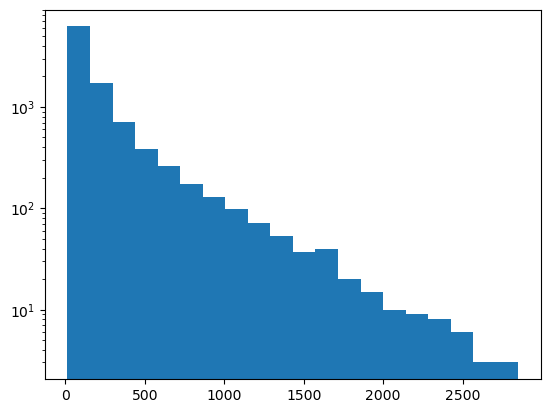

,energy,cosdec,events
0,10.0,0.000000,1964
1,10.0,0.010101,1871
2,10.0,0.020202,1820
3,10.0,0.030303,1840
4,10.0,0.040404,1608
...,...,...,...
9995,100.0,0.959596,35
9996,100.0,0.969697,27
9997,100.0,0.979798,18
9998,100.0,0.989899,30


In [3]:
def generate_data(N, sin2theta=0.9, dm2=2.4e-3):
    
    cosdec =  np.linspace(0, 1, N) # N steps in cos(declination) from 0 to 1 
    energy = 10**np.linspace(1, 2, N) # N steps in log10(energy) from 10 to 100 GeV
    
    events_df = run_experiment(energy,cosdec,sin2theta,dm2)
    
    return events_df

events_df = generate_data(100)

plt.hist(events_df["events"], bins=20)
plt.yscale('log')

plt.show() 
events_df

In [4]:
def atmo_event_rate_fit(data, sin2theta, dm2):
    energy, cosdec = data[0,:], data[1,:]
    return atmo_event_rate(energy, cosdec, sin2theta, dm2)

events_df_ = generate_data(100, sin2theta=0.75, dm2=1.2e-3) # generate data with different parameters to test the fit

popt, pcov = curve_fit(atmo_event_rate_fit, xdata=np.vstack((events_df_["energy"], events_df_["cosdec"])), ydata=events_df_["events"], p0=[0.5, 1e-3])
perr = np.sqrt(np.diag(pcov))

print(f"Best fit sin2theta: {popt[0]:.3e} +/- {perr[0]:.3e}")
print(f"Best fit dm2: {popt[1]:.3e} +/- {perr[1]:.3e}")


Best fit sin2theta: 7.505e-01 +/- 6.836e-04
Best fit dm2: 1.200e-03 +/- 1.809e-06


In [5]:
from scipy.misc import derivative

def logprobability_sin(sin2theta, dm2, energy, cos_theta): # recycled the rate function to work with scipy derivatives
    if energy == 0:
        return 0
    flux = 1e5*energy**-1.7
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 
    return np.log(flux*osc_prop)


def logprobability_dm2(dm2, sin2theta,  energy, cos_theta):
    if energy == 0:
        return 0
    flux = 1e5*energy**-1.7
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 
    return np.log(flux*osc_prop)

def CramerRao_bound(data_df, sin2theta, dm2):
    energy, cosdec = data_df["energy"].to_numpy(), data_df["cosdec"].to_numpy()
    #calculate numerical derivatives of the LLH wrt sin2theta and dm2
    dLLH_dm2 = 0
    dLLH_sin2theta = 0
    for i in range(len(energy)):
        dLLH_dm2 += derivative(logprobability_dm2, dm2, dx=1e-4, args = (sin2theta, energy[i], cosdec[i]))
        dLLH_sin2theta += derivative(logprobability_sin, sin2theta,dx=1e-4, args = (dm2, energy[i], cosdec[i]))
    return  1/dLLH_dm2**2, 1/dLLH_sin2theta**2

In [6]:
events_df = generate_data(10, sin2theta=0.9, dm2=2.4e-3) 
sigma_dm2_10, sigma_sin2theta_10 = np.sqrt(CramerRao_bound(events_df, 0.9, 2.4e-3))

print(f"MV / Cramer-Rao bound for sin2theta: {sigma_sin2theta_10:.3e}")
print(f"MV / Cramer-Rao bound for dm2: {sigma_dm2_10:.3e}")

MV / Cramer-Rao bound for sin2theta: 7.724e-03
MV / Cramer-Rao bound for dm2: 9.653e-05


In [7]:
events_df = generate_data(100, sin2theta=0.9, dm2=2.4e-3) # what happens with a larger dataset?
sigma_dm2_100, sigma_sin2theta_100 = np.sqrt(CramerRao_bound(events_df, 0.9, 2.4e-3))

print(f"MV / Cramer-Rao bound for sin2theta: {sigma_sin2theta_100:.3e}")
print(f"MV / Cramer-Rao bound for dm2: {sigma_dm2_100:.3e}")

MV / Cramer-Rao bound for sin2theta: 7.415e-05
MV / Cramer-Rao bound for dm2: 8.193e-07


In [8]:
events_df = generate_data(500, sin2theta=0.9, dm2=2.4e-3) 
sigma_dm2_500, sigma_sin2theta_500 = np.sqrt(CramerRao_bound(events_df, 0.9, 2.4e-3))

print(f"MV / Cramer-Rao bound for sin2theta: {sigma_sin2theta_500:.3e}")
print(f"MV / Cramer-Rao bound for dm2: {sigma_dm2_500:.3e}")

MV / Cramer-Rao bound for sin2theta: 2.957e-06
MV / Cramer-Rao bound for dm2: 3.212e-08


Fraction of measurements within the Cramer-Rao bound: 0.940


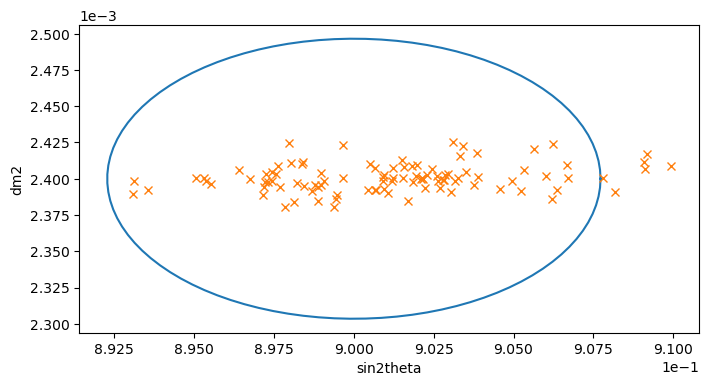

In [9]:
# run 100 simulations and check how often the measurement is within the Cramer-Rao bound (1D)

N_sim = 100
N_bins = 10

sin2theta_true = 0.9
dm2_true = 2.4e-3

sin2theta_vals = []
dm2_vals = []
count = 0

for sim in range(N_sim):
    data = generate_data(N_bins, sin2theta=sin2theta_true, dm2=dm2_true)
    
    popt, pcov = curve_fit(atmo_event_rate_fit, xdata=np.vstack((data["energy"], data["cosdec"])), ydata=data["events"], p0=[0.5, 1e-3])
    
    sin2theta_vals.append(popt[0])
    dm2_vals.append(popt[1])
    
    if abs(popt[0] - sin2theta_true) < sigma_sin2theta_10 and abs(popt[1] - dm2_true) < sigma_dm2_10:
        count += 1
        
print(f"Fraction of measurements within the Cramer-Rao bound: {count/N_sim:.3f}")

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111,)

t = np.linspace(0, 2*np.pi, 100)

ax.plot(sin2theta_true+sigma_sin2theta_10*np.cos(t) , dm2_true+sigma_dm2_10*np.sin(t) )

ax.plot(sin2theta_vals, dm2_vals, "x")

ax.set_xlabel("sin2theta")
ax.set_ylabel("dm2")

ax.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
plt.show()

Fraction of measurements within the Cramer-Rao bound: 0.020


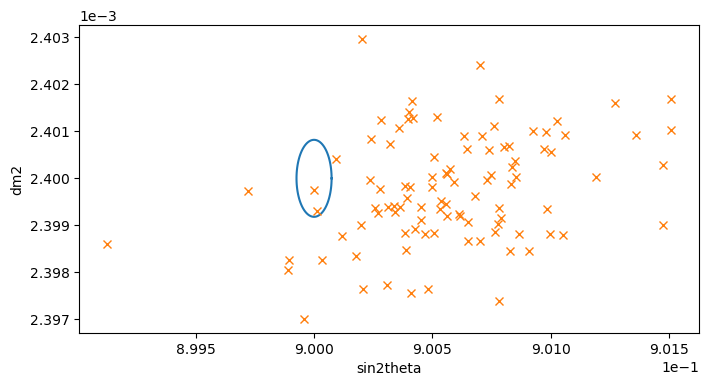

In [10]:
# Increase no. of data points per sim and check again

N_sim = 100
N_bins = 100

sin2theta_true = 0.9
dm2_true = 2.4e-3

sin2theta_vals = []
dm2_vals = []
count = 0

for sim in range(N_sim):
    data = generate_data(N_bins, sin2theta=sin2theta_true, dm2=dm2_true)
    
    popt, pcov = curve_fit(atmo_event_rate_fit, xdata=np.vstack((data["energy"], data["cosdec"])), ydata=data["events"], p0=[0.5, 1e-3])
    
    sin2theta_vals.append(popt[0])
    dm2_vals.append(popt[1])
    
    if abs(popt[0] - sin2theta_true) < sigma_sin2theta_100 and abs(popt[1] - dm2_true) < sigma_dm2_100:
        count += 1
        
print(f"Fraction of measurements within the Cramer-Rao bound: {count/N_sim:.3f}")

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111,)

t = np.linspace(0, 2*np.pi, 100)

ax.plot(sin2theta_true+sigma_sin2theta_100*np.cos(t) , dm2_true+sigma_dm2_100*np.sin(t) )

ax.plot(sin2theta_vals, dm2_vals, "x")

ax.set_xlabel("sin2theta")
ax.set_ylabel("dm2")

ax.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
plt.show()